# SMILES homework
This notebook contains the individual assignments of the SMILES homework.

In [1]:
import numpy as np
from scipy import stats
import pandas as pd
from matplotlib import pyplot as plt

## 1. Combinations
How many possible combinations are there of 165 isobaric compounds and 10 chemical structures?

There are $10^{165}$ possible realizations. Think of it as a password with 165 places and 10 possible characters. 

If every combination took 1 second to compute this would take $10^{165}$ seconds. which amounts to

In [2]:
print(f'{1e165 / (365 * 60 * 60 * 24):.2e} years')

3.17e+157 years


## 2. Data-analysis
This is how the original csv was processed to fix faults.

In [3]:
# df = pd.read_csv('smiles.csv')
# # There were some faulty values in the initial data. This is how it was cleared.
# # Faulty values
# df.loc[37, 'k 9'] = np.nan
# df.loc[111,'k 3'] = 3.01e-12
# df.loc[112,'k 9'] = 43.07e-12
# df['k 9'] = pd.to_numeric(df['k 9'], errors='coerce')
# df['k 8'] = pd.to_numeric(df['k 8'], errors='coerce')
# df['k 3'] = pd.to_numeric(df['k 3'], errors='coerce')

In [4]:
# df_k = df.loc[:155, 'k 1':'k 10']
# df_k.dtypes

In [5]:
# This used to contain values which made automatic parsing impossible. But fixed as above.
df = pd.read_excel('SMILES_HU_2021_v1.xlsx')

In [6]:
df_k = df.loc[:, 'k 1':]
# Convert the df to a numpy array, faster computation in the loop.
reaction_rates = df_k.to_numpy()

The OH reactivity for each compound can be calculated from the reaction rate as
$$
k_{x_{OH}} = [x] \cdot k_x \cdot 10^{-6}.
$$
where $[x]$ is the mean concentration of the sum formula. The concentration of compound x has to be converted from ppbv to molecules per m$^3$
$$
[x]_{m^3} = [x]_{ppbv} \cdot 10^{-9}\frac{N}{V}
$$
where $N=6.023 \cdot 10^{23}$ and $V=24.4 \cdot 10^{-3}$. This is implemented as 

In [7]:
# We need to convert our OH recation rates to OH reactivity.
# First we have to convert the mixing ratios to concentrations.
N = 6.023 * 1e23
V = 24.4 * 1e-3
mean_concentration = df['mean concentration (ppbv)'] * 1e-9 * N / V
OH_reaction_rates = reaction_rates * mean_concentration.to_numpy()[:, None] * 1e-6

### 2.1 Random sampling

We can now draw an arbitary (1e5) number of random realizations from our sample

In [8]:
# Create nr of realizations, draw k random reactants for each realization. Not sure if this is correct? 
# Should every realization contain 165 reactants?
nr = int(1e5)
results = np.empty(nr)
for i in range(nr):
    rows = OH_reaction_rates.shape[0]
    rows_choice = np.arange(rows)
    r_cols = np.random.choice(OH_reaction_rates.shape[1], rows)
    # Not sure if this the correct way to calculate the overall reaction rate for a realization.
    results[i] = np.nansum(OH_reaction_rates[rows_choice, r_cols])
# Remove realizations that consists of NaN.
results = results[np.isfinite(results)] 

Inspecting the basic statistics of the realizations

In [9]:
values = ['n', 'Min and max', 'Mean', 'Variance', 'Skewness', 'Kurtosis']
for i in zip(values, stats.describe(results)):
    print(f'{i[0]}: \t{i[1]}')

n: 	100000
Min and max: 	(3.762038067607295, 18.200230495713566)
Mean: 	9.634320025646675
Variance: 	4.2536303475984125
Skewness: 	0.3494734647494307
Kurtosis: 	-0.22798122286384093


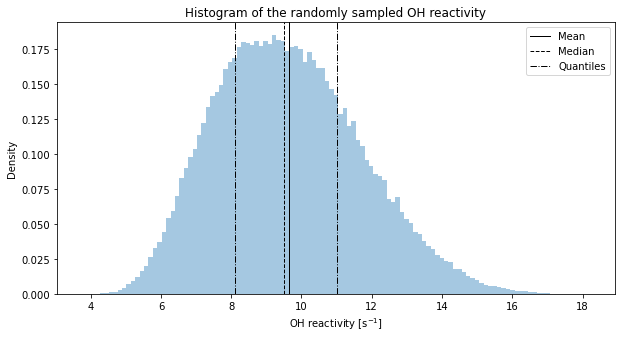

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(results, bins='auto', density=True, alpha=0.4);

# Indicate mean and median in the plot.
ax.axvline(results.mean(), color='black', lw=1, label='Mean')
ax.axvline(np.median(results), color='black', ls='--', lw=1, label='Median')
# And the quantiles
ax.axvline(np.percentile(results, 25), c='black', ls='-.', lw=1, label='Quantiles')
ax.axvline(np.percentile(results, 75), c='black', ls='-.', lw=1)
ax.set_title('Histogram of the randomly sampled OH reactivity');
ax.set_xlabel('OH reactivity [s$^{-1}$]')
ax.set_ylabel('Density')
ax.legend();

The $10^5$ random realizations results in a slightly right skewed distribution - indicated by a slightly positive skewness and a mean which is greater than the median. In other words, the sample does not follow a normal distribution. 

### 2.2 Fit distributions
The sample is treated as continuous due to the large sample size. Based on the characteristics of the sample (skewness etc), the following continuous distributions are fit to the data. For each distribution the root mean squared error is calculated for evaluation. 

In [11]:
# List the distributions we want to use.
dist_list = ['gamma', 'gumbel_r', 'weibull_min', 'beta', 'johnsonsb', 'loggamma', 'pearson3']
# Initilaize empty lists for storage of params and test statistic.
params = []
rmse = []
x = np.linspace(results.min(), results.max(), nr)
# Fit each distribution to the sample data and evaluate the godness of fit.
for i in dist_list:
    dist = getattr(stats, i)
    pars = dist.fit(results)
    params.append(pars)
    # Calculate the sum of the squared errors to evaluate the fit.
    error = np.sqrt(np.mean((dist.pdf(x, *pars) - results)**2))
    rmse.append(error)
    

The distribtution with the lowest SSE, i.e. best fit, is the

In [12]:
dist_list[rmse.index(min(rmse))]

'weibull_min'

with the following parameters

In [13]:
params[rmse.index(min(rmse))]

(3.085619904474857, 3.760189195917934, 6.5740142142050235)

Most of the tried distributions actually fit the data well (see plot below). The RMSE of the johsonsb, beta and weibull_min distributions only differ at the fifth decimal.

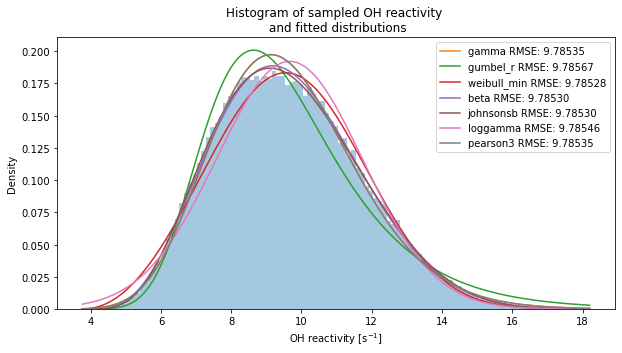

In [14]:
# Plot hist with fitted distributions
fig, ax1 = plt.subplots(ncols=1, figsize=(10, 5))
ax1.hist(results, density=True, bins='auto', alpha=0.4)
x = np.linspace(results.min(), results.max(), 200)
# Does an enumeration so that accessing the test statistic and name of distribution is possible. 
# Could maybe also work with zip?
for i, j in enumerate(params):
    dist = getattr(stats, dist_list[i])
    # Star indicates that we want to unpack the tuple and use contents as arguments for pdf.
    pdf = dist.pdf(x, *j)
    # Label consists of the name of the distribution and the summed squared error.
    ax1.plot(x, pdf, label=f'{dist_list[i]} RMSE: {rmse[i]:.5f}')
ax1.set_title('Histogram of sampled OH reactivity \n and fitted distributions')
ax1.set_ylabel('Density');
ax1.set_xlabel('OH reactivity [s$^{-1}$]')
ax1.legend();


Plot of the three best fitting distributions.

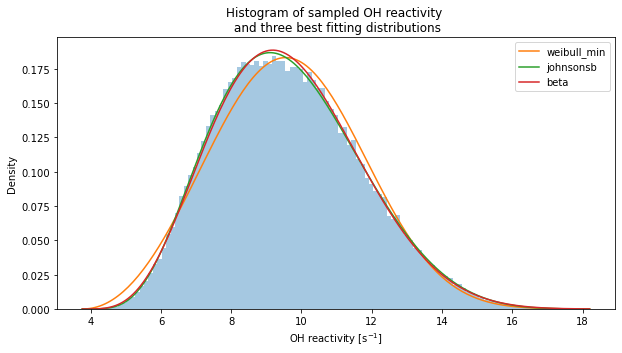

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(results, alpha=0.4, bins='auto', density=True);
# Sort the SSE and used their pre-sort indexes for retreieving the data. Only plot the three best.
for i in np.argsort(rmse)[:3]:
    dist = getattr(stats, dist_list[i])
    pdf = dist.pdf(x, *params[i])
    ax.plot(x, pdf, label=f'{dist_list[i]}')
ax.set_title('Histogram of sampled OH reactivity \n and three best fitting distributions')
ax.set_ylabel('Density');
ax.set_xlabel('OH reactivity [s$^{-1}$]')
ax.legend();

## 2.3 Summary
All the best fitting distributions are contious distributions with some degree of assymmetry around the mean. The three distributions with the lowest RMSE are the beta, johnsonsb and weibull_min (formerly fechet_r) distributions. Compared to the beta and johnsonsb, the weibull_min distribution covers the upper median of the data to a higher degree but over or under estimates the two lower quartiles respectively. According to the RMSE, the weibull_min has the best fit.

The sampeled distribution of random realizations has a mean of

In [18]:
print(f'{results.mean():.3f} OH reactions /s')

9.634


and a minimum/maximum of

In [22]:
print(f'{results.min():.3f}, {results.max():.3f} OH reactions /s')

3.762, 18.200 OH reactions /s


The weibull_min distribution achieved the best fitting distribution with the following parameters

In [24]:
best_pars = params[rmse.index(min(rmse))]
print(f'alpha={best_pars[0]:.3f}, scale={best_pars[1]:.3f} and location={best_pars[2]:.3f}')

alpha=3.086, scale=3.760 and location=6.574
